# RAIL Prior

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp

import nz_prior as nz

## Load Data

In [2]:
dummy = np.load('../tests/dummy.npz')
zs = dummy['zs']
nzs = dummy['pzs']
dz = np.mean(np.diff(zs))
zs_edges = np.append(zs - dz/2, zs[-1] + dz/2)
q = qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":nzs})

In [3]:
base = nz.PriorBase(q)

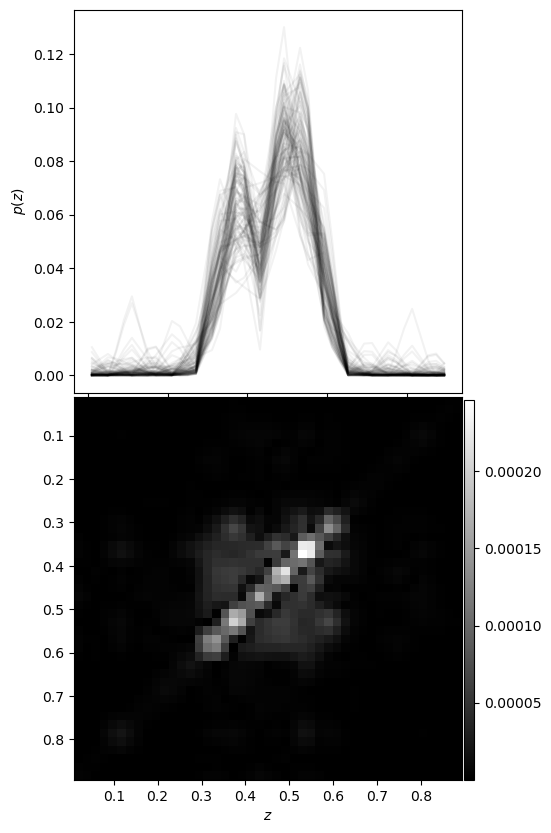

In [4]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(base.z, base.nzs[i], 'k-', alpha=0.05)
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(base.nz_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
plt.show()

# Shifts

In [5]:
shifts = nz.PriorShifts(q)

In [6]:
pz_fid = [shifts.z, shifts.nz_mean]

In [7]:
shifted_pzs = np.array([nz.shift_model(pz_fid, shifts.sample_prior()["delta_z"])[1] for i in range(100)])

In [8]:
shifted_cov = np.cov(shifted_pzs.T)

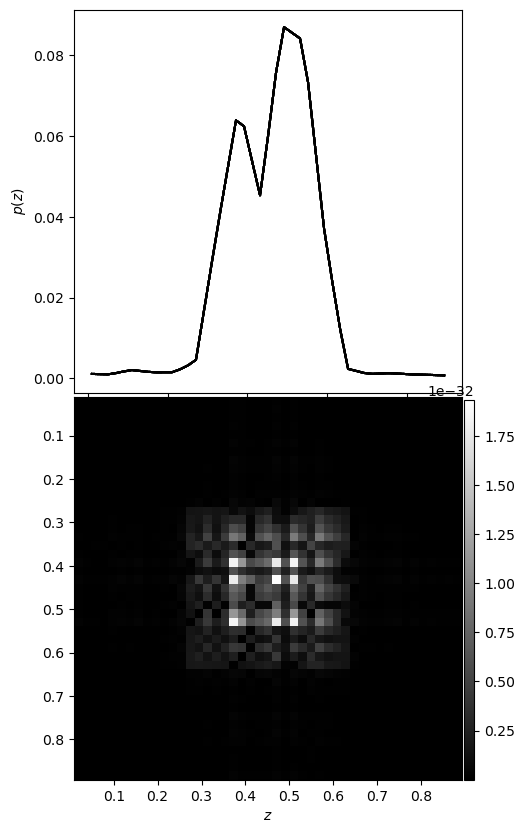

In [9]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    pz = shifted_pzs[i]
    axis[0].plot(shifts.z, pz, 'k-', alpha=0.05)
axis[0].errorbar(shifts.z, shifts.nz_mean, yerr=np.sqrt(np.diag(shifted_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(shifted_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/shifts.png')
plt.show()

# Shifts & Widths

In [10]:
SnW = nz.PriorShiftsWidths(q)

In [11]:
SnW_pzs = []
for i in range(100):
    prior_sample = SnW.sample_prior()
    shift = prior_sample["delta_z"]
    width = prior_sample["width_z"]
    pz = nz.shift_and_width_model(pz_fid, shift, width)[1]
    SnW_pzs.append(pz)
SnW_pzs = np.array(SnW_pzs)

In [12]:
SnW_cov = np.cov(SnW_pzs.T)

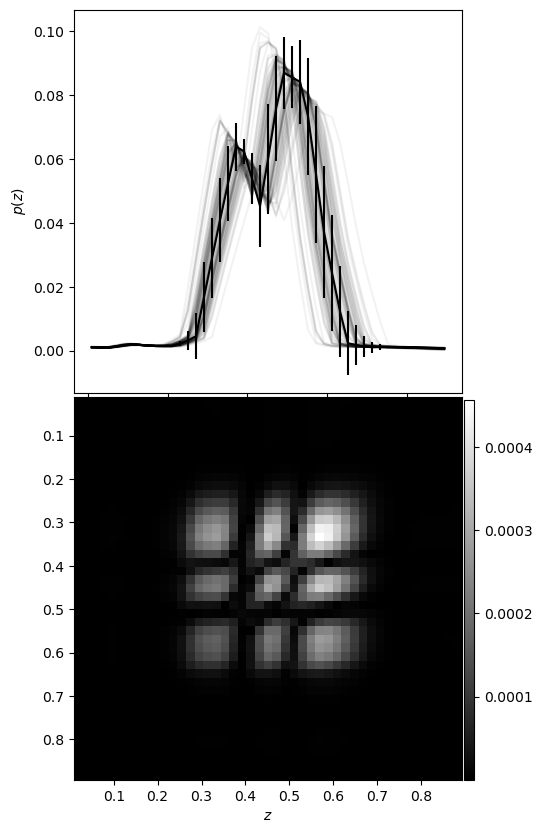

In [13]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(SnW.z, SnW_pzs[i], 'k-', alpha=0.05)
axis[0].errorbar(SnW.z, SnW.nz_mean, yerr=np.sqrt(np.diag(SnW_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(SnW_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/moments.png')
plt.show()

# Moments

In [21]:
moments = nz.PriorMoments(q)

The covariance matrix will be regularized
The covariance matrix will be diagonalized


In [24]:
moments._get_params_names()

['nz_0',
 'nz_1',
 'nz_2',
 'nz_3',
 'nz_4',
 'nz_5',
 'nz_6',
 'nz_7',
 'nz_8',
 'nz_9',
 'nz_10',
 'nz_11',
 'nz_12',
 'nz_13',
 'nz_14',
 'nz_15',
 'nz_16',
 'nz_17',
 'nz_18',
 'nz_19',
 'nz_20',
 'nz_21',
 'nz_22',
 'nz_23',
 'nz_24',
 'nz_25',
 'nz_26',
 'nz_27',
 'nz_28',
 'nz_29',
 'nz_30',
 'nz_31',
 'nz_32',
 'nz_33',
 'nz_34',
 'nz_35',
 'nz_36',
 'nz_37',
 'nz_38',
 'nz_39',
 'nz_40',
 'nz_41',
 'nz_42',
 'nz_43',
 'nz_44',
 'nz_45',
 'nz_46',
 'nz_47',
 'nz_48',
 'nz_49',
 'nz_50',
 'nz_51',
 'nz_52',
 'nz_53',
 'nz_54',
 'nz_55',
 'nz_56',
 'nz_57',
 'nz_58',
 'nz_59',
 'nz_60',
 'nz_61',
 'nz_62',
 'nz_63',
 'nz_64',
 'nz_65',
 'nz_66',
 'nz_67',
 'nz_68',
 'nz_69',
 'nz_70',
 'nz_71',
 'nz_72',
 'nz_73',
 'nz_74',
 'nz_75',
 'nz_76',
 'nz_77',
 'nz_78',
 'nz_79',
 'nz_80',
 'nz_81',
 'nz_82',
 'nz_83',
 'nz_84',
 'nz_85',
 'nz_86',
 'nz_87',
 'nz_88',
 'nz_89',
 'nz_90',
 'nz_91',
 'nz_92',
 'nz_93',
 'nz_94',
 'nz_95',
 'nz_96',
 'nz_97',
 'nz_98',
 'nz_99']

In [15]:
moments_nzs = np.array([list(moments.sample_prior().values()) for i in range(100)])

In [16]:
moments_cov = np.cov(moments_nzs.T)

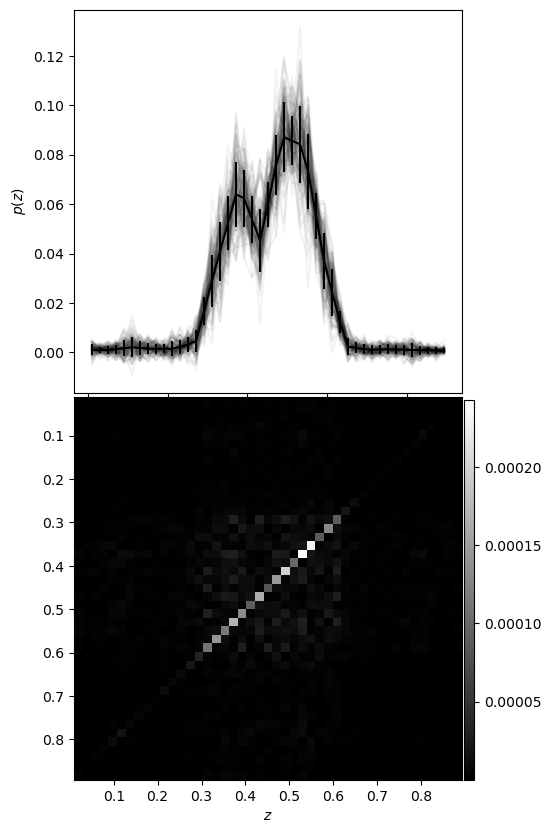

In [17]:
figure, axis = plt.subplots(2, 1, figsize=(5,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
for i in range(100):
    axis[0].plot(moments.z, moments_nzs[i], 'k-', alpha=0.05)
axis[0].errorbar(moments.z, moments.nz_mean, yerr=np.sqrt(np.diag(moments_cov)), fmt='k-')
axis[0].set_ylabel(r'$p(z)$')
im = axis[1].imshow(abs(moments_cov), aspect='auto',
                    origin='lower', cmap='gray',
                    extent=[min(zs), max(zs), max(zs), min(zs)])
axis[1].set_xlabel(r'$z$')
cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
figure.colorbar(im, cax=cbar_ax)
#plt.savefig('docs/source/assets/moments.png')
plt.show()